In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from sub_projects.ray_optimization.configuration import params_to_func
from ray_optim.plot import Plot
import torch
from matplotlib import pyplot as plt

In [ ]:
from typing import List, Tuple


samples_count = 2
compensated = [torch.randn(3, 1000, 2) * 0.1 + 0.1 for _ in range(samples_count)]
target = [torch.randn(3, 1000, 2) + torch.tensor([5., 0.]).repeat(3, 1000, 1) for _ in range(samples_count)]
without_compensation = compensated

def is_out_of_lim(torch_list: List[torch.Tensor], lims: Tuple[float], coordinate_idx=0):
    is_out_of_min = True in [element[:, :, coordinate_idx].mean() < lims[0] for element in torch_list]
    is_out_of_max = True in [element[:, :, coordinate_idx].mean() > lims[1] for element in torch_list]
    return is_out_of_min | is_out_of_max
def mean(torch_list: List[torch.Tensor], coordinate_idx: int =0):
    return torch.cat([element[:, :, coordinate_idx] for element in torch_list], dim=1).mean()

def switch_lims_if_out_of_lim(torch_list, lims_x, lims_y):
    if is_out_of_lim(torch_list, lims_x, 0):
        mean_x = mean(torch_list, 0)
        lims_x = (lims_x[0]+mean_x, lims_x[1]+mean_x)
    if is_out_of_lim(torch_list, lims_y, 1):
        mean_y = mean(torch_list, 1)
        lims_y = (lims_y[0]+mean_y, lims_y[1]+mean_y)
    return lims_x, lims_y
print(is_out_of_lim(target, (-2., 2.), coordinate_idx=1))
lims_x = (-2.0, 2.0)
lims_y = (-2.0, 2.0)
lims_x, lims_y = switch_lims_if_out_of_lim(target, lims_x=lims_x, lims_y=lims_y)
fig = Plot.fixed_position_plot(
    compensated, target, without_compensation, lims_x, lims_y, epoch=12
)
plt.figure(fig)

In [ ]:
fig = Plot.plot_data([torch.randn(3, 1000, 2) for i in range(3)])
plt.figure(fig)

In [ ]:
samples_count = 1
compensated = [torch.randn(3, 1000, 2) * 0.1 + 0.1 for _ in range(samples_count)]
target = [torch.randn(3, 1000, 2) * 0.1 - 3 for _ in range(samples_count)]
without_compensation = compensated
fig = Plot.fixed_position_plot(
    compensated, target, without_compensation, (-2.0, 2.0), (-2.0, 2.0), epoch=12
)
plt.figure(fig)

In [ ]:

parameters = {
            "x_var": [-5., 5.],
            "y_var": [0., 10.],
            }
search_space = params_to_func(parameters)()
real_params = params_to_func({"x_var": 0, "y_var":5})()
predicted_params = params_to_func({"x_var": -2.5, "y_var":10.})()
Plot.plot_param_comparison(epoch=42, real_params=real_params, predicted_params=predicted_params, search_space=search_space)

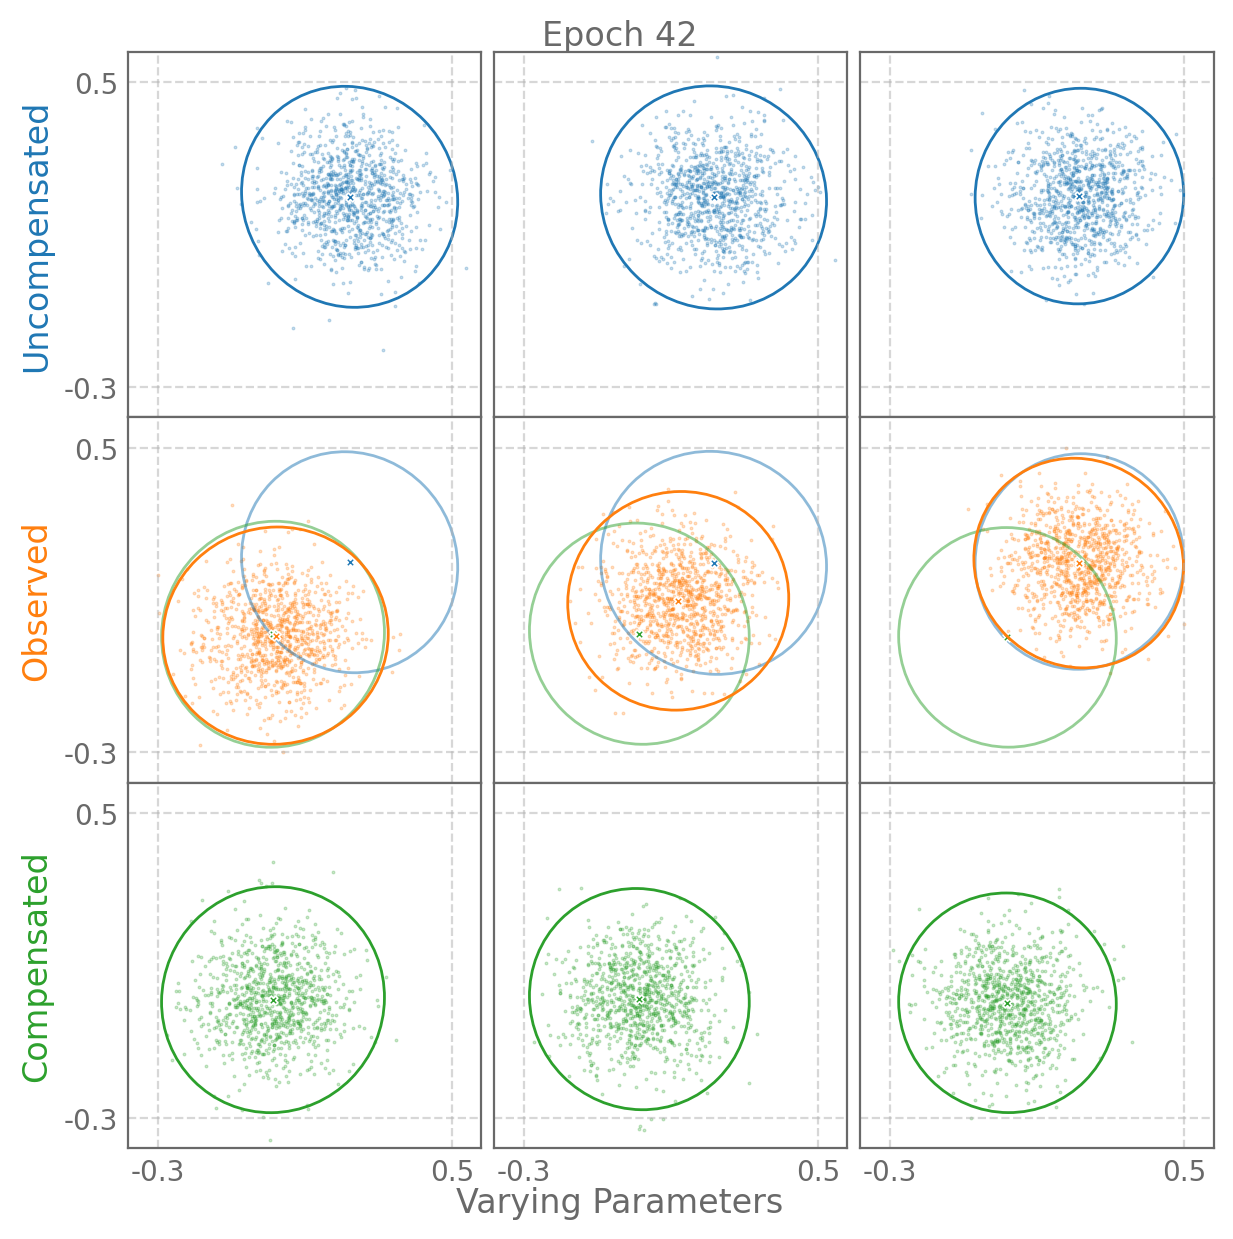

In [2]:
samples_count = 3
compensated = [torch.randn(3, 1000, 2) * 0.1 for _ in range(samples_count)]
target = [torch.randn(3, 1000, 2) * 0.1 +0.1 * i for i in range(samples_count)]
without_compensation = [torch.randn(3, 1000, 2) * 0.1 + 0.2 for _ in range(samples_count)]
fig = Plot.compensation_plot(
    compensated, target, without_compensation, epoch=42, covariance_ellipse=True
)
plt.figure(fig)

In [ ]:
%matplotlib inline
plt.scatter([i for i in range(10)], [i for i in range(10)], marker='X', edgecolor="#000", s=40.0)
